# **Network Stock Portfolio Optimization**

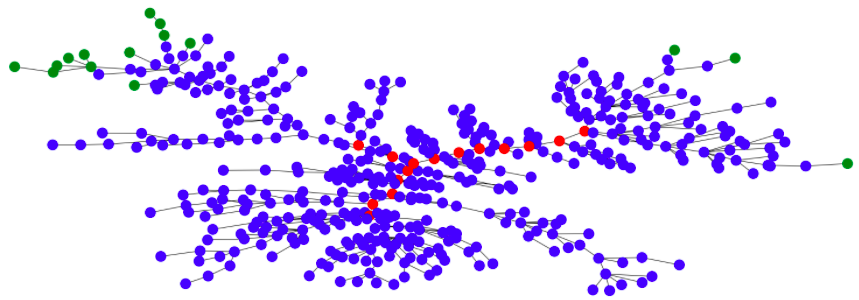

## **Context and Problem Statement**

Active investing in the asset management industry **aims to beat the stock market’s average returns**, for which portfolio managers track a particular index and try to beat that index by creating their own portfolios. 

Portfolio construction involves selection of stocks that have a **higher probability of giving better returns** in comparison to the tracking index, like **S&P 500**. In this project, we will use the concept of Network Analysis to select a basket of stocks and create two portfolios. We will then simulate portfolio value by investing a certain amount, keeping the portfolio for an entire year and we will then compare it against the S&P 500 index. 

In this project we will try to follow the approach mentioned in the below research paper: 

**[Dynamic portfolio strategy using a clustering
approach](https://arxiv.org/pdf/1608.03058.pdf)**

## **Proposed Approach**

- Collect the price data for all S&P 500 components from 2011 till 2020
- Compute log returns for the S&P 500 components for same time period
- Compute the **correlation matrix** for the above log returns
- Find out the **Top n central and peripheral stocks** based on the following network topological parameters:
    - Degree centrality
    - Betweenness centrality
    - Distance on degree criterion
    - Distance on correlation criterion
    - Distance on distance criterion
- Simulate the performance of central and peripheral portfolios against the performance of S&P 500 for the year 2021    

## **Loading the Libraries**

We will need to first install the library - `pandas_datareader` using `!pip install pandas_datareader`

In [ ]:
import tqdm
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import plotly.express as px
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas_datareader.data as web

import warnings
warnings.filterwarnings('ignore')

## **Getting the S&P 500 Components**

Beautiful Soup is a library that makes it easy to scrape information from web pages.

https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [ ]:
#Extracting list of S&P 500 companies using BeautifulSoup.
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text.strip('\n')
    tickers.append(ticker)
    
tickers = [ticker.replace('.', '-') for ticker in tickers] # list of S&P 500 stocks

## **Getting the Price Data for all the S&P 500 components in the last 10 years**

In [ ]:
# price_data = web.DataReader(tickers, 'yahoo', start='2011-01-01', end='2020-12-31')
# price_data = price_data['Adj Close']
# price_data.to_csv('snp500_price_data_2011_to_2020.csv')

In [ ]:
price_data = pd.read_csv('snp500_price_data_2011_to_2020.csv', index_col=[0])

In [ ]:
price_data.head()

MMM       AOS        ABT  ABBV   ABMD        ACN       ATVI  \
Date                                                                            
2010-12-31  63.855606  8.113162  17.986767   NaN   9.61  39.143620  11.245819   
2011-01-03  64.218163  8.125947  17.952976   NaN   9.80  39.224346  11.318138   
2011-01-04  64.129395  8.100383  18.121916   NaN   9.80  38.966022  11.327178   
2011-01-05  64.129395  8.285738  18.121916   NaN  10.03  38.974094  11.110217   
2011-01-06  63.737186  8.289999  18.084377   NaN  10.05  39.119389  11.083097   

                  ADM       ADBE        ADP  ...        XEL       XLNX  XYL  \
Date                                         ...                              
2010-12-31  22.385578  30.780001  31.271172  ...  16.221039  23.216919  NaN   
2011-01-03  22.623722  31.290001  31.791464  ...  16.227924  23.569420  NaN   
2011-01-04  22.608845  31.510000  31.676586  ...  16.296804  23.665552  NaN   
2011-01-05  22.713020  32.220001  32.183357  ...  16.200367  23.745670  NaN   
2011-01-06  23.583750  32.270000  32.433369  ...  16.186602  24.146229  NaN   

                  YUM       ZBRA        ZBH       ZION  ZTS  CEG  OGN  
Date                                                                   
2010-12-31  28.547478  37.990002  49.212429  21.089169  NaN  NaN  NaN  
2011-01-03  28.570745  38.200001  50.395058  21.907326  NaN  NaN  NaN  
2011-01-04  28.134232  37.840000  49.725819  21.550467  NaN  NaN  NaN  
2011-01-05  28.268110  37.799999  49.762482  21.672325  NaN  NaN  NaN  
2011-01-06  28.465996  37.480000  48.222305  21.611391  NaN  NaN  NaN  

[5 rows x 505 columns]

## **Missing Data due to Index Rebalancing**

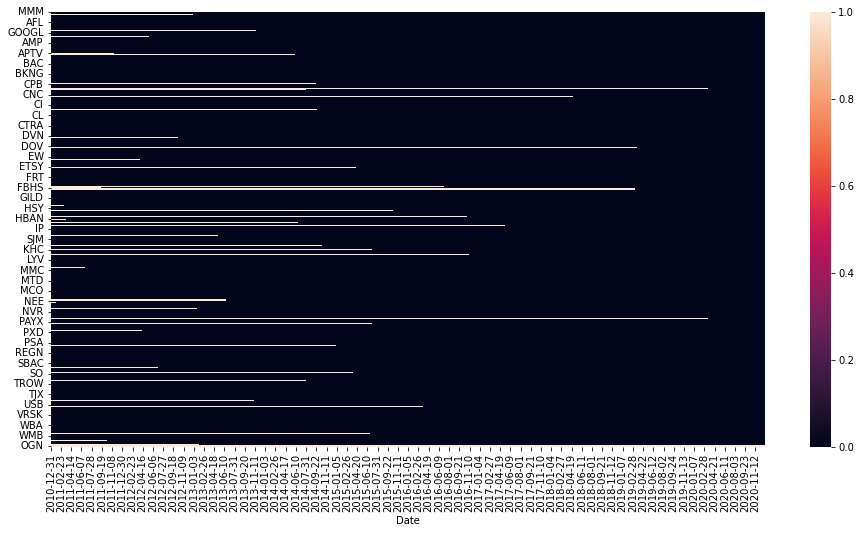

In [ ]:
figure = plt.figure(figsize=(16, 8))
sns.heatmap(price_data.T.isnull());

The missing data is due to the fact that **certain stocks may move out of the S&P 500** and **certain stocks may enter the S&P 500** in this respective timeframe

In [ ]:
price_data_cleaned = price_data.dropna(axis=1) # dropping na values columnwise

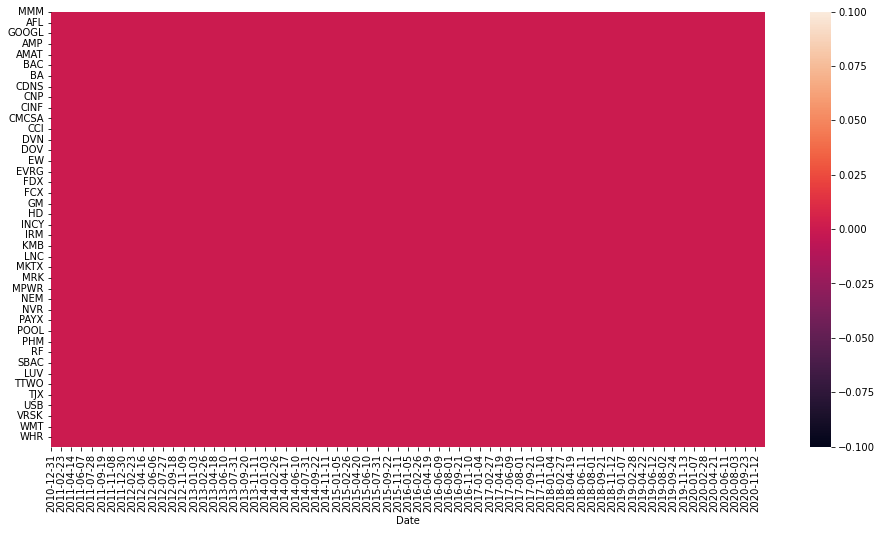

In [ ]:
figure = plt.figure(figsize=(16, 8))
sns.heatmap(price_data_cleaned.T.isnull());

The null values are removed - the data is clean and the plot also helps in finding that there are no missing values.

## **Getting Yearwise Data**

In [ ]:
def get_year_wise_snp_500_data(data, year):
    year_wise_data = data.loc['{}-01-01'.format(year):'{}-12-31'.format(year)]
    
    return year_wise_data

In [ ]:
# Getting year wise data of S&P stocks from 2011 to 2020
snp_500_2011 = get_year_wise_snp_500_data(price_data_cleaned, 2011)
snp_500_2012 = get_year_wise_snp_500_data(price_data_cleaned, 2012)
snp_500_2013 = get_year_wise_snp_500_data(price_data_cleaned, 2013)
snp_500_2014 = get_year_wise_snp_500_data(price_data_cleaned, 2014)
snp_500_2015 = get_year_wise_snp_500_data(price_data_cleaned, 2015)
snp_500_2016 = get_year_wise_snp_500_data(price_data_cleaned, 2016)
snp_500_2017 = get_year_wise_snp_500_data(price_data_cleaned, 2017)
snp_500_2018 = get_year_wise_snp_500_data(price_data_cleaned, 2018)
snp_500_2019 = get_year_wise_snp_500_data(price_data_cleaned, 2019)
snp_500_2020 = get_year_wise_snp_500_data(price_data_cleaned, 2020)

## **Computing the Daily Log Returns**

Statistically, **simple stock returns are always assumed to follow a Log Normal distribution**. It is therefore plausible to use properties of the Normal distribution in statistical estimation for Log returns, but not for the simple returns.

Stock Returns analysis is a time series analysis, in which you also take care of stationarity which is normally obtained from Log returns but not from simple returns.

In [ ]:
# Calculating daily log returns by subtracting between two days with the help of shift function
log_returns_2011 = np.log(snp_500_2011.shift(1)) - np.log(snp_500_2011)
log_returns_2012 = np.log(snp_500_2012.shift(1)) - np.log(snp_500_2012)
log_returns_2013 = np.log(snp_500_2013.shift(1)) - np.log(snp_500_2013)
log_returns_2014 = np.log(snp_500_2014.shift(1)) - np.log(snp_500_2014)
log_returns_2015 = np.log(snp_500_2015.shift(1)) - np.log(snp_500_2015)
log_returns_2016 = np.log(snp_500_2016.shift(1)) - np.log(snp_500_2016)
log_returns_2017 = np.log(snp_500_2017.shift(1)) - np.log(snp_500_2017)
log_returns_2018 = np.log(snp_500_2018.shift(1)) - np.log(snp_500_2018)
log_returns_2019 = np.log(snp_500_2019.shift(1)) - np.log(snp_500_2019)
log_returns_2020 = np.log(snp_500_2020.shift(1)) - np.log(snp_500_2020)

## **Computing the Correlation of Returns**

In [ ]:
# Computing adjacency matrix:
return_correlation_2011 = log_returns_2011.corr()
return_correlation_2012 = log_returns_2012.corr()
return_correlation_2013 = log_returns_2013.corr()
return_correlation_2014 = log_returns_2014.corr()
return_correlation_2015 = log_returns_2015.corr()
return_correlation_2016 = log_returns_2016.corr()
return_correlation_2017 = log_returns_2017.corr()
return_correlation_2018 = log_returns_2018.corr()
return_correlation_2019 = log_returns_2019.corr()
return_correlation_2020 = log_returns_2020.corr()

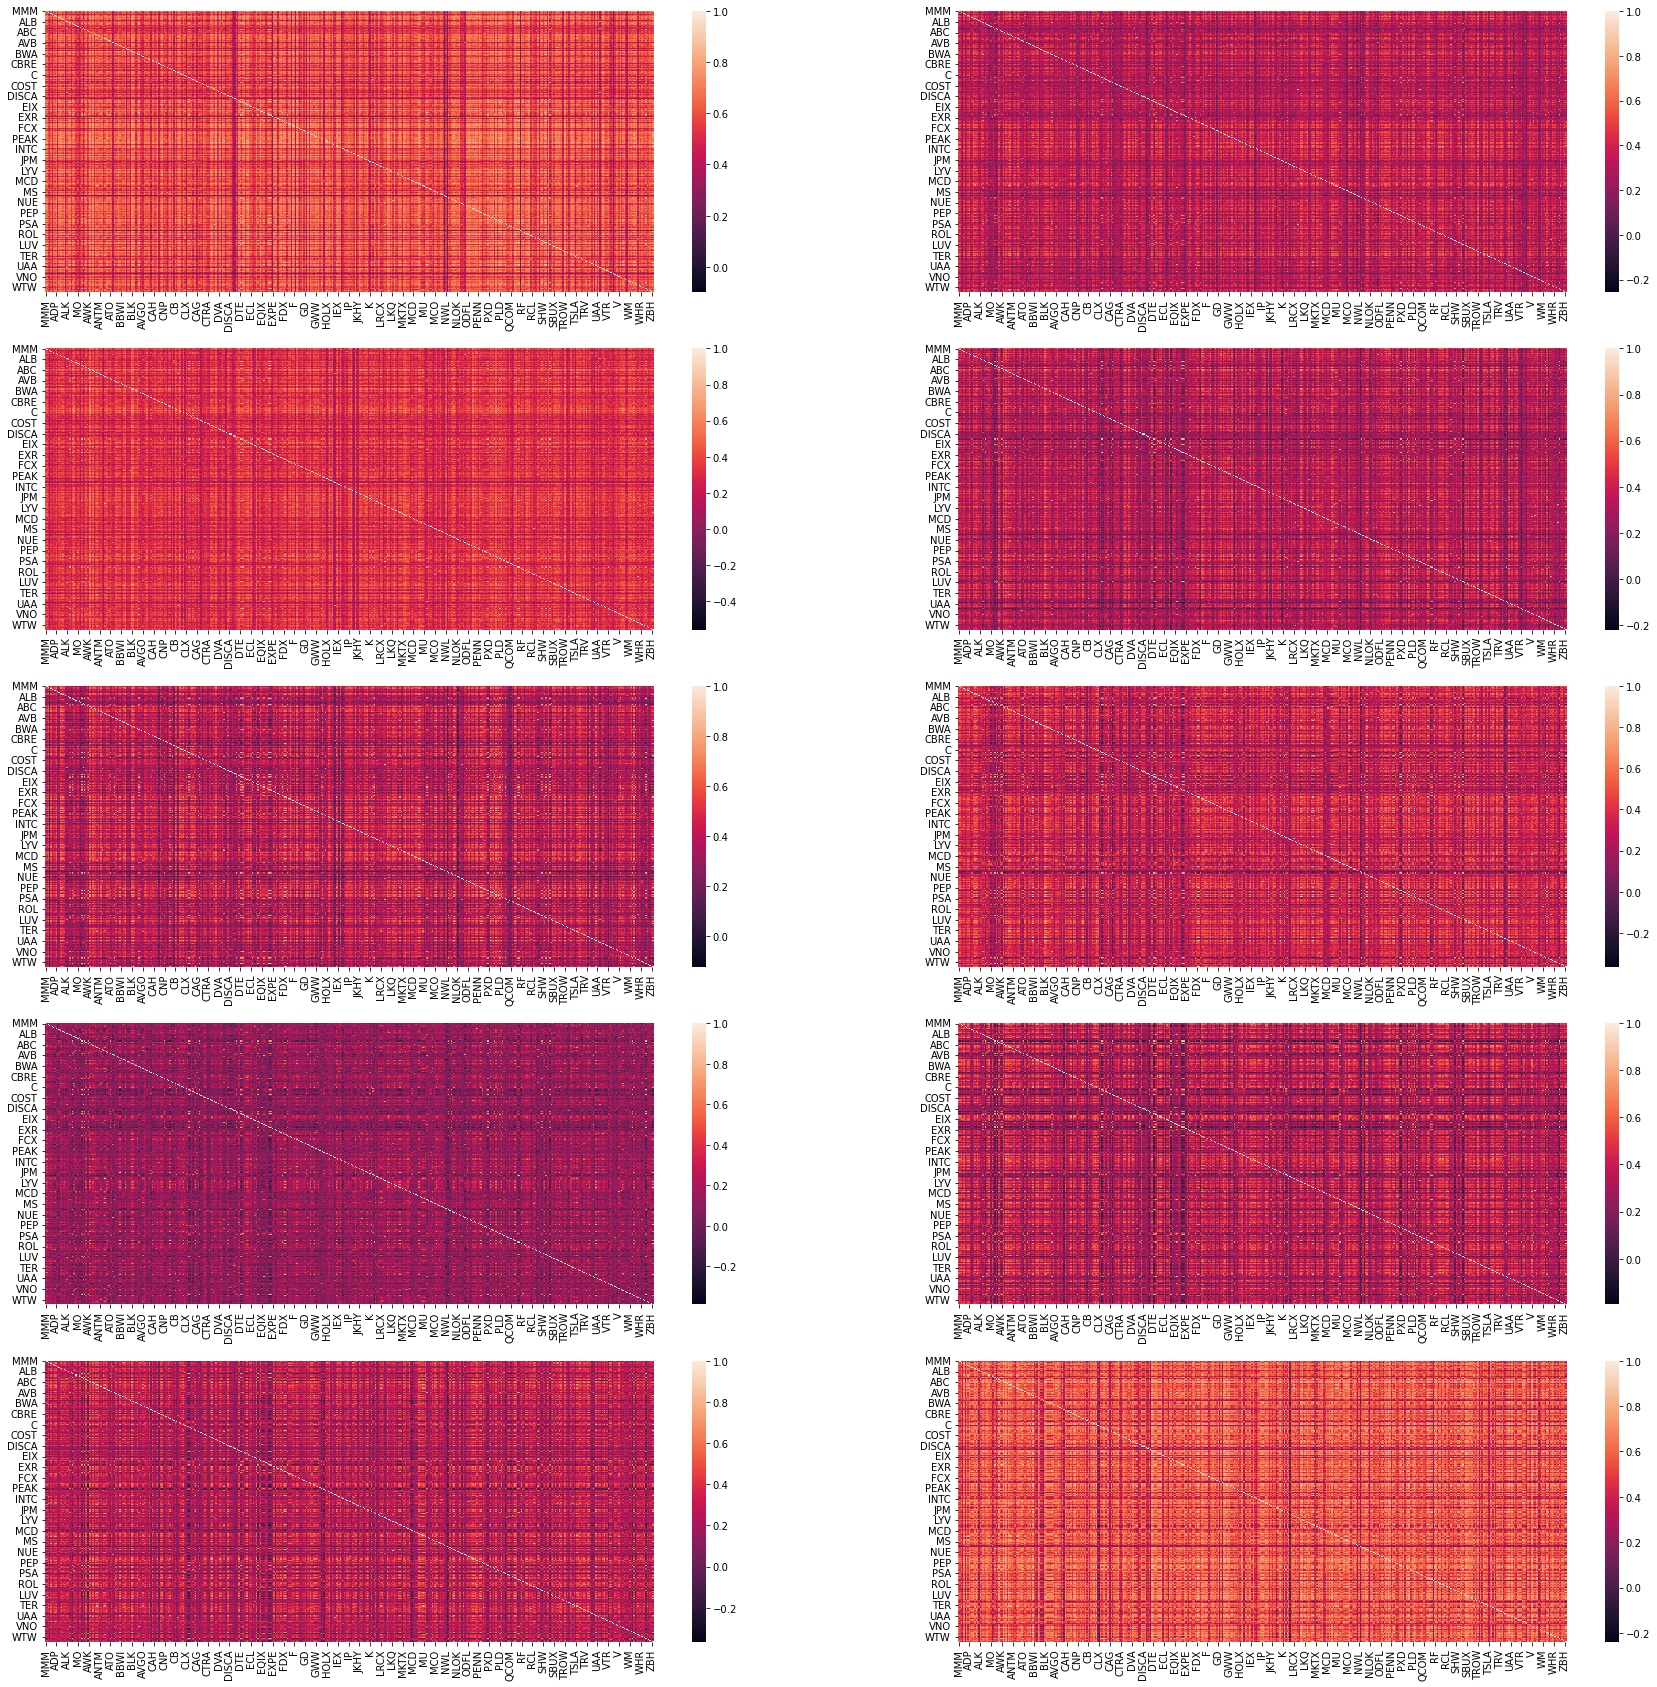

In [ ]:
figure, axes = plt.subplots(5, 2, figsize=(30, 30))
sns.heatmap(return_correlation_2011, ax=axes[0, 0]);
sns.heatmap(return_correlation_2012, ax=axes[0, 1]);
sns.heatmap(return_correlation_2013, ax=axes[1, 0]);
sns.heatmap(return_correlation_2014, ax=axes[1, 1]);
sns.heatmap(return_correlation_2015, ax=axes[2, 0]);
sns.heatmap(return_correlation_2016, ax=axes[2, 1]);
sns.heatmap(return_correlation_2017, ax=axes[3, 0]);
sns.heatmap(return_correlation_2018, ax=axes[3, 1]);
sns.heatmap(return_correlation_2019, ax=axes[4, 0]);
sns.heatmap(return_correlation_2020, ax=axes[4, 1]);

## **Inferences**

The first plot for the year 2011 shows that there is high correlation among the stocks. It shows that since in 2011 there was a market crash and there was volatility in the market, the prices of the stock went down along with the other stocks and this is the reason for high correlation.

Similarly in 2012, 2014 and 2017 the market is kind of stable, and hence the correlation among stocks is low.

In 2020, due to the COVID pandemic and the volatility in the market, the prices of the stock went down or up along with other stocks, and this is the reason for high correlation.

## **Creating Graphs**

In [ ]:
graph_2011 = nx.Graph(return_correlation_2011)

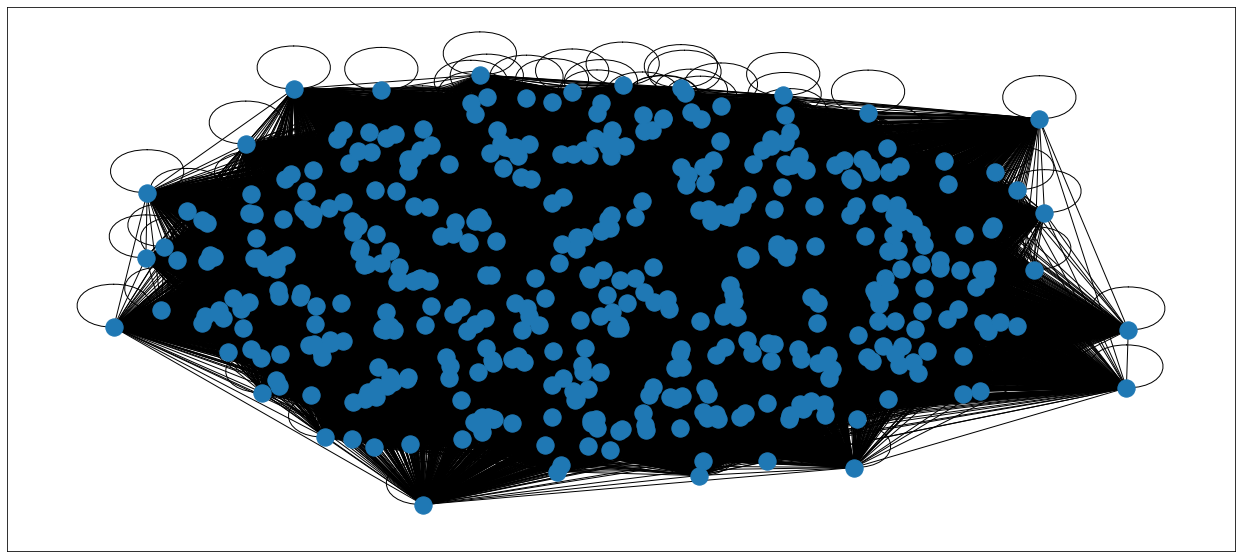

In [ ]:
figure = plt.figure(figsize=(22, 10))
nx.draw_networkx(graph_2011, with_labels=False)

## **Filtering Graphs using MST**

You can find more on MST [here](https://visualgo.net/en/mst)

In [ ]:
distance_2011 = np.sqrt(2 * (1 - return_correlation_2011))
distance_2012 = np.sqrt(2 * (1 - return_correlation_2012))
distance_2013 = np.sqrt(2 * (1 - return_correlation_2013))
distance_2014 = np.sqrt(2 * (1 - return_correlation_2014))
distance_2015 = np.sqrt(2 * (1 - return_correlation_2015))
distance_2016 = np.sqrt(2 * (1 - return_correlation_2016))
distance_2017 = np.sqrt(2 * (1 - return_correlation_2017))
distance_2018 = np.sqrt(2 * (1 - return_correlation_2018))
distance_2019 = np.sqrt(2 * (1 - return_correlation_2019))
distance_2020 = np.sqrt(2 * (1 - return_correlation_2020))

Before the construction of the MST graph, **the correlation coefficient is converted into a distance.**

In [ ]:
distance_2011_graph = nx.Graph(distance_2011)
distance_2012_graph = nx.Graph(distance_2012)
distance_2013_graph = nx.Graph(distance_2013)
distance_2014_graph = nx.Graph(distance_2014)
distance_2015_graph = nx.Graph(distance_2015)
distance_2016_graph = nx.Graph(distance_2016)
distance_2017_graph = nx.Graph(distance_2017)
distance_2018_graph = nx.Graph(distance_2018)
distance_2019_graph = nx.Graph(distance_2019)
distance_2020_graph = nx.Graph(distance_2020)

In [ ]:
graph_2011_filtered = nx.minimum_spanning_tree(distance_2011_graph)
graph_2012_filtered = nx.minimum_spanning_tree(distance_2012_graph)
graph_2013_filtered = nx.minimum_spanning_tree(distance_2013_graph)
graph_2014_filtered = nx.minimum_spanning_tree(distance_2014_graph)
graph_2015_filtered = nx.minimum_spanning_tree(distance_2015_graph)
graph_2016_filtered = nx.minimum_spanning_tree(distance_2016_graph)
graph_2017_filtered = nx.minimum_spanning_tree(distance_2017_graph)
graph_2018_filtered = nx.minimum_spanning_tree(distance_2018_graph)
graph_2019_filtered = nx.minimum_spanning_tree(distance_2019_graph)
graph_2020_filtered = nx.minimum_spanning_tree(distance_2020_graph)

We choose the MST method to filter out the network graph in each window so as to eliminate the redundancies and noise, and still maintain significant links.

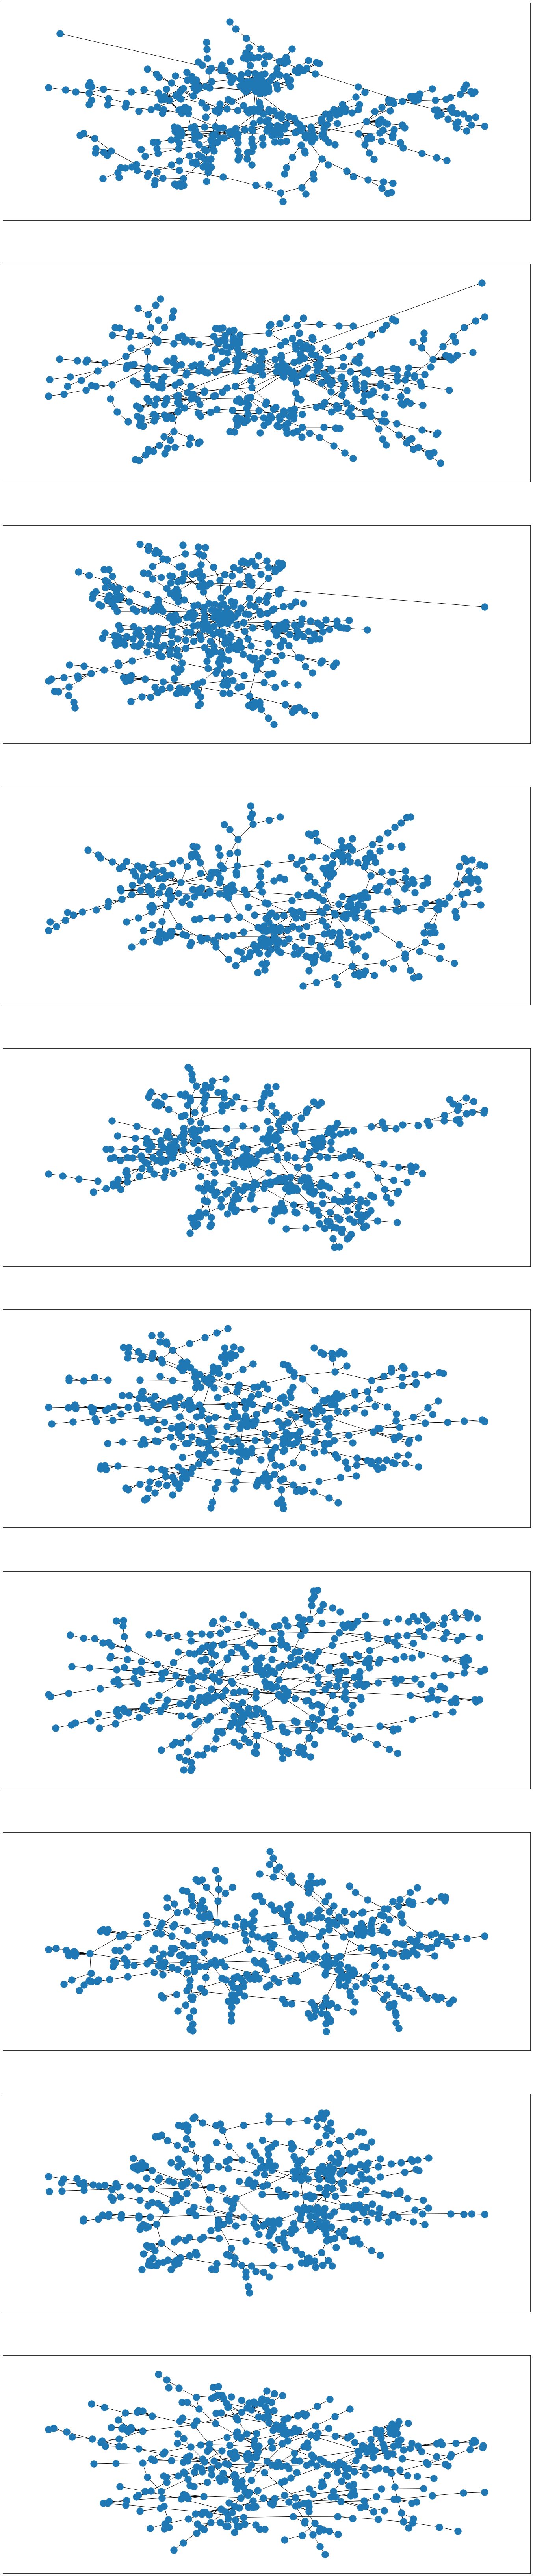

In [ ]:
figure, axes = plt.subplots(10, 1, figsize=(24, 120))
nx.draw_networkx(graph_2011_filtered, with_labels=False, ax=axes[0])
nx.draw_networkx(graph_2012_filtered, with_labels=False, ax=axes[1])
nx.draw_networkx(graph_2013_filtered, with_labels=False, ax=axes[2])
nx.draw_networkx(graph_2014_filtered, with_labels=False, ax=axes[3])
nx.draw_networkx(graph_2015_filtered, with_labels=False, ax=axes[4])
nx.draw_networkx(graph_2016_filtered, with_labels=False, ax=axes[5])
nx.draw_networkx(graph_2017_filtered, with_labels=False, ax=axes[6])
nx.draw_networkx(graph_2018_filtered, with_labels=False, ax=axes[7])
nx.draw_networkx(graph_2019_filtered, with_labels=False, ax=axes[8])
nx.draw_networkx(graph_2020_filtered, with_labels=False, ax=axes[9])

On plotting the graphs, we see that the network looks different every year, and no two yearwise graphs look very similar.

## **Computing Graph Statistics over Time**

In [ ]:
average_degree_connectivity = []
average_shortest_path_length = []
year = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

for graph in [graph_2011_filtered, graph_2012_filtered, graph_2013_filtered, graph_2014_filtered, graph_2015_filtered, 
             graph_2016_filtered, graph_2017_filtered, graph_2018_filtered, graph_2019_filtered, graph_2020_filtered]:
    average_shortest_path_length.append(nx.average_shortest_path_length(graph))

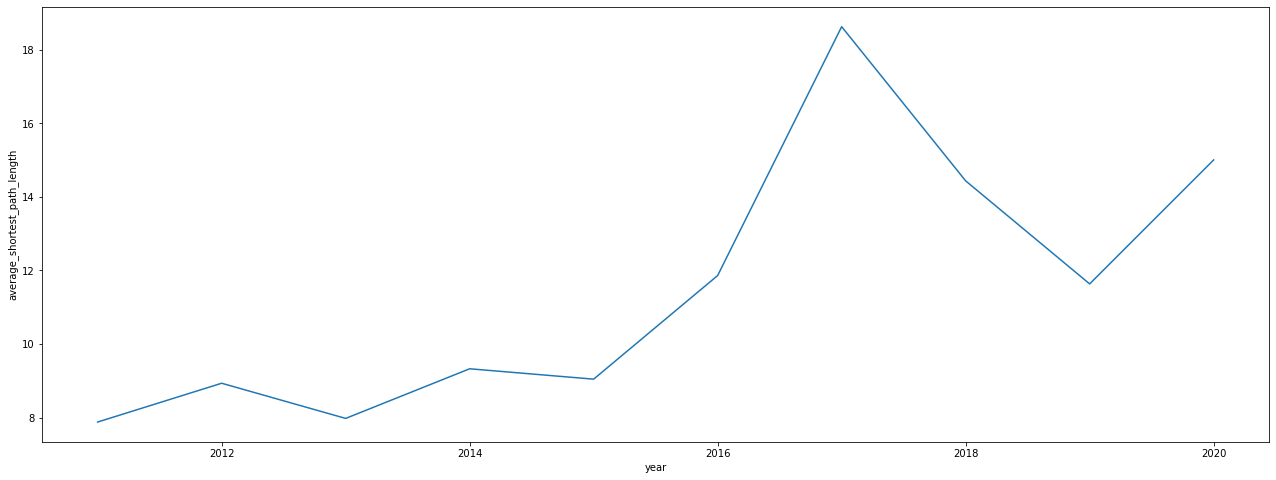

In [ ]:
figure = plt.figure(figsize=(22, 8))
sns.lineplot(x='year', y='average_shortest_path_length', 
             data=pd.DataFrame({'year': year, 'average_shortest_path_length': average_shortest_path_length}));

## **Portfolio Construction**

In [ ]:
log_returns_2011_till_2020 = np.log(price_data_cleaned.shift(1)) - np.log(price_data_cleaned)
return_correlation_2011_till_2020 = log_returns_2011_till_2020.corr()

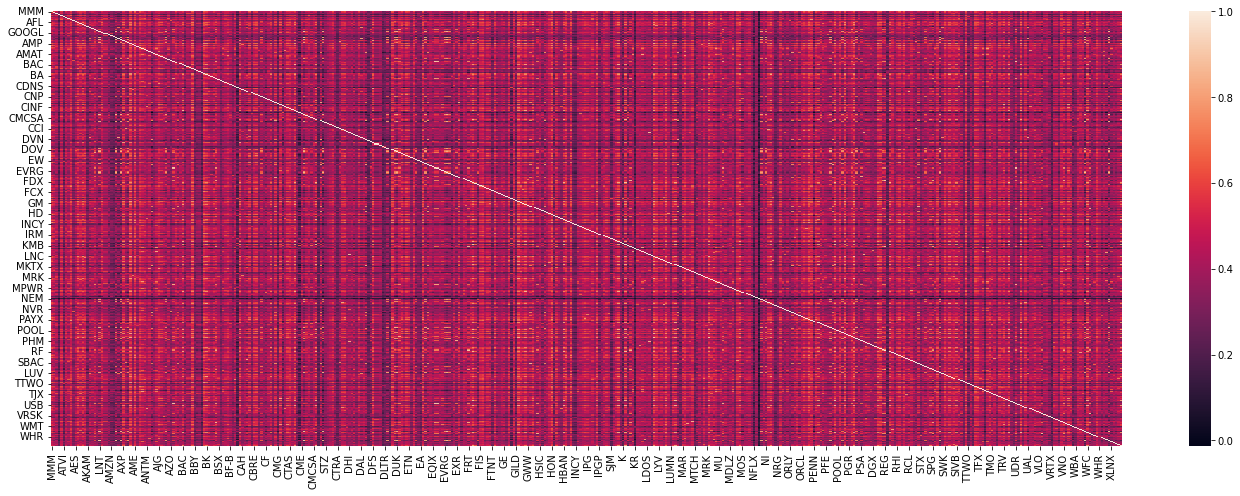

In [ ]:
figure = plt.figure(figsize=(24, 8))
sns.heatmap(return_correlation_2011_till_2020);

In [ ]:
distance_2011_till_2020 = np.sqrt(2 * (1 - return_correlation_2011_till_2020))
distance_2011_till_2020_graph = nx.Graph(distance_2011_till_2020)
distance_2011_till_2020_graph_filtered = nx.minimum_spanning_tree(distance_2011_till_2020_graph)

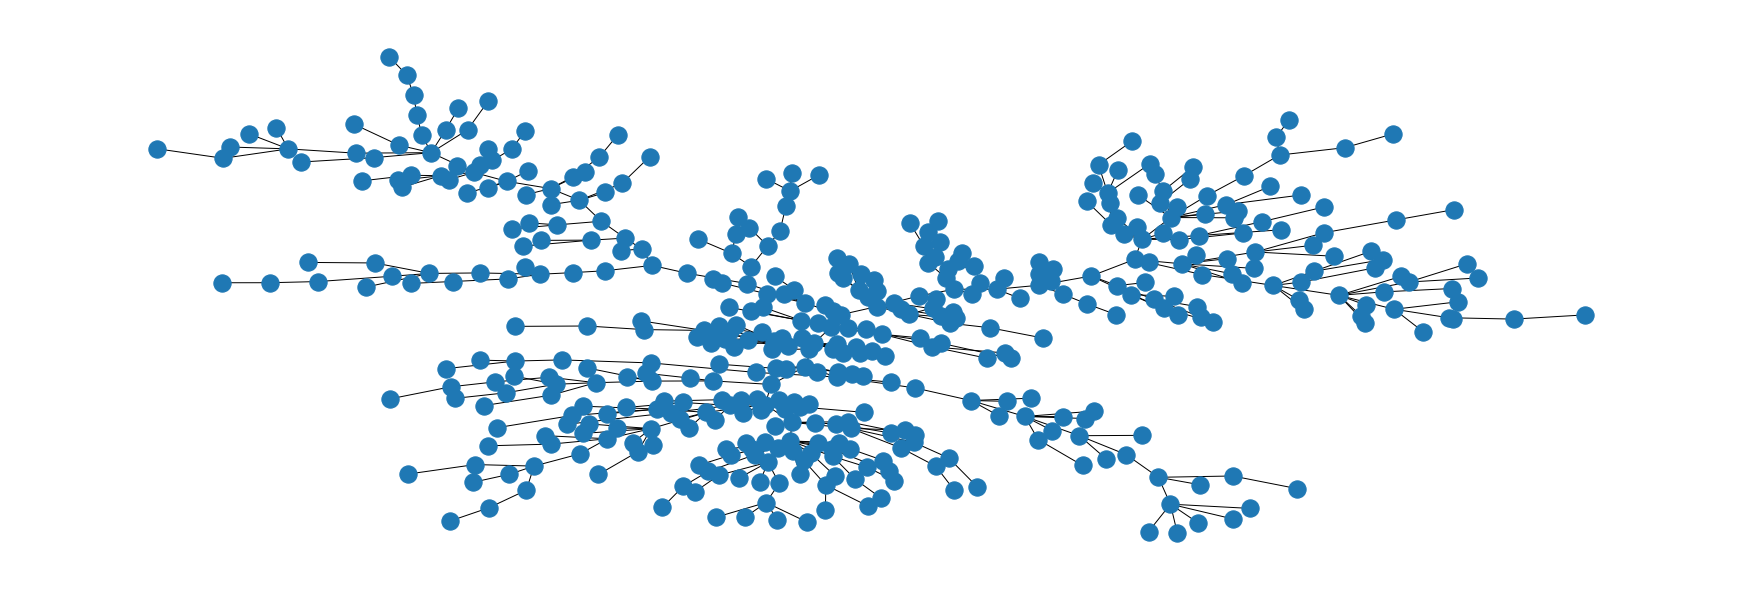

In [ ]:
figure = plt.figure(figsize=(24, 8))
nx.draw_kamada_kawai(distance_2011_till_2020_graph_filtered, with_labels=False)

In [ ]:
degree_centrality = nx.degree_centrality(distance_2011_till_2020_graph_filtered)
closeness_centrality = nx.closeness_centrality(distance_2011_till_2020_graph_filtered)
betweenness_centrality = nx.betweenness_centrality(distance_2011_till_2020_graph_filtered)

In [ ]:
keys = []
values = []

for key, value in degree_centrality.items():
    keys.append(key)
    values.append(value)

dc_data = pd.DataFrame({'stocks': keys, 'degree_centrality': values}).sort_values('degree_centrality', ascending=False)
px.bar(data_frame=dc_data, x='stocks', y='degree_centrality', template='plotly_dark')

**Degree centrality** is the simplest centrality measure. It
defines the relative significance of a stock in terms of the
**number of edges incident upon it.** The stocks with the high
scores will influence the behavior of many other
stocks which are directly connected to it. 

Based on this
measure, **HON has the highest number of edges with other
stocks and hence the highest degree centrality.**

In [ ]:
keys = []
values = []

for key, value in closeness_centrality.items():
    keys.append(key)
    values.append(value)

cc_data = pd.DataFrame({'stocks': keys, 'closeness_centrality': values}).sort_values('closeness_centrality', 
                                                                                       ascending=False)
px.bar(data_frame=cc_data, x='stocks', y='closeness_centrality', template='plotly_dark')

**Closeness centrality** also involves the shortest path
between all possible pairs of stocks on a network. 

It is
defined as the average number of shortest paths between a
stock and all other stocks reachable from it.

In [ ]:
keys = []
values = []

for key, value in betweenness_centrality.items():
    keys.append(key)
    values.append(value)

bc_data = pd.DataFrame({'stocks': keys, 'betweenness_centrality': values}).sort_values('betweenness_centrality', 
                                                                                       ascending=False)
px.bar(data_frame=bc_data, x='stocks', y='betweenness_centrality', template='plotly_dark')

**Betweenness centrality** is the sum of the fraction of all possible shortest paths between any stocks that pass through a stock. It is used to **quantify the control of a stock on information flow in the network.** 

So, the stock with the highest score is considered a significant stock in terms of its role in coordinating the information among stocks. 

## **Selecting Stocks based on Network Topological Parameters**

In [ ]:
# we already computed degree centrality above

# we already computed betweenness centrality above

# distance on degree criterion
distance_degree_criteria = {}
node_with_largest_degree_centrality = max(dict(degree_centrality), key=dict(degree_centrality).get)
for node in distance_2011_till_2020_graph_filtered.nodes():
    distance_degree_criteria[node] = nx.shortest_path_length(distance_2011_till_2020_graph_filtered, node, 
                                                             node_with_largest_degree_centrality)

# distance on correlation criterion
distance_correlation_criteria = {}
sum_correlation = {}

for node in distance_2011_till_2020_graph_filtered.nodes():
    neighbors = nx.neighbors(distance_2011_till_2020_graph_filtered, node)
    sum_correlation[node] = sum(return_correlation_2011_till_2020[node][neighbor] for neighbor in neighbors)

node_with_highest_correlation = max(sum_correlation, key=sum_correlation.get)
    
for node in distance_2011_till_2020_graph_filtered.nodes():
    distance_correlation_criteria[node] = nx.shortest_path_length(distance_2011_till_2020_graph_filtered, node, 
                                                             node_with_highest_correlation)    

# distance on distance criterion
distance_distance_criteria = {}
mean_distance = {}

for node in distance_2011_till_2020_graph_filtered.nodes():
    nodes = list(distance_2011_till_2020_graph_filtered.nodes())
    nodes.remove(node)
    distance_distance = [nx.shortest_path_length(distance_2011_till_2020_graph_filtered, node, ns) for ns in nodes]
    mean_distance[node] = np.mean(distance_distance)
    
node_with_minimum_mean_distance = min(mean_distance, key=mean_distance.get)

for node in distance_2011_till_2020_graph_filtered.nodes():
    distance_distance_criteria[node] = nx.shortest_path_length(distance_2011_till_2020_graph_filtered, node, 
                                                             node_with_minimum_mean_distance)

**Distance refers to the smallest length from a node to the central node of the network**. 

Here,
three types of definitions of central node are introduced to reduce the error caused by a single
method. 

Therefore three types of distances are described here.

**1. Distance on degree criterion** (Ddegree), the central node is the one that has the largest degree.

**2. Distance on correlation criterion** (Dcorrelation), the central node is the one with the highest value of the sum of correlation coefficients with its neighbors.

**3. Distance on distance criterion** (Ddistance), the central node is the one that produces the lowest value for the mean distance.

In [ ]:
node_stats = pd.DataFrame.from_dict(dict(degree_centrality), orient='index')
node_stats.columns = ['degree_centrality']
node_stats['betweenness_centrality'] = betweenness_centrality.values()
node_stats['average_centrality'] = 0.5 * (node_stats['degree_centrality'] + node_stats['betweenness_centrality'])

node_stats['distance_degree_criteria'] = distance_degree_criteria.values()
node_stats['distance_correlation_criteria'] = distance_correlation_criteria.values()
node_stats['distance_distance_criteria'] = distance_distance_criteria.values()
node_stats['average_distance'] = (node_stats['distance_degree_criteria'] + node_stats['distance_correlation_criteria'] +
                                  node_stats['distance_distance_criteria']) / 3

In [ ]:
node_stats.head()

degree_centrality  betweenness_centrality  average_centrality  \
MMM            0.002227                0.000000            0.001114   
AOS            0.004454                0.022073            0.013264   
ABT            0.008909                0.056584            0.032746   
ABMD           0.002227                0.000000            0.001114   
ACN            0.006682                0.008899            0.007790   

      distance_degree_criteria  distance_correlation_criteria  \
MMM                          2                              2   
AOS                          6                              6   
ABT                          9                              9   
ABMD                        10                             10   
ACN                         16                             16   

      distance_distance_criteria  average_distance  
MMM                            7          3.666667  
AOS                            5          5.666667  
ABT                            8          8.666667  
ABMD                           9          9.666667  
ACN                            9         13.666667

We use the parameters defined above to select the portfolios. 

**The nodes with the largest 10% of degree or betweenness centrality are chosen to be in the central portfolio.** 

**The nodes whose degree equals to 1 or betweenness centrality equals to 0 are chosen to be in the peripheral portfolio.**


Similarly, we define the node's ranking in the top 10% of distance as the stocks of the peripheral portfolios, and the bottom 10% as the stocks of the central portfolios. 

The central portfolios and peripheral portfolios represent two opposite sides of correlation and agglomeration. Generally speaking, central stocks play a vital role in the market and impose a strong influence on other stocks. On the other hand, the correlations between peripheral stocks are weak and contain much more noise than those of the central stocks.

In [ ]:
central_stocks = node_stats.sort_values('average_centrality', ascending=False).head(15)
central_portfolio = [stock for stock in central_stocks.index.values]

In [ ]:
peripheral_stocks = node_stats.sort_values('average_distance', ascending=False).head(15)
peripheral_portfolio = [stock for stock in peripheral_stocks.index.values]

### **Selecting the top 15 stocks for both Central Stocks and Peripheral Stocks**

In [ ]:
color = []

for node in distance_2011_till_2020_graph_filtered:
    if node in central_portfolio:
        color.append('red')
        
    elif node in peripheral_portfolio:
        color.append('green')
        
    else:
        color.append('blue')

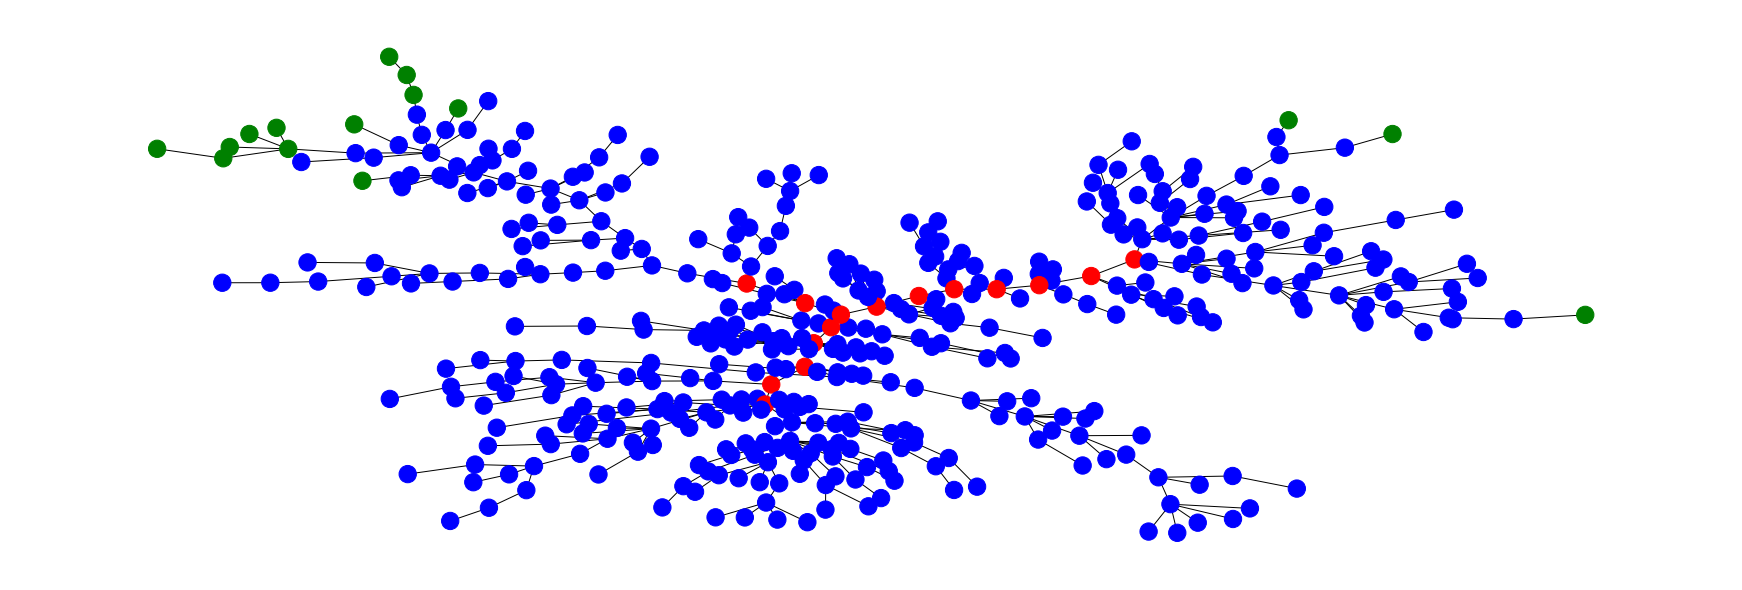

In [ ]:
figure = plt.figure(figsize=(24, 8))
nx.draw_kamada_kawai(distance_2011_till_2020_graph_filtered, with_labels=False, node_color=color)

Here, **the red stocks are the central portfolio stocks, and the green ones are the peripheral portfolio stocks.**

## **Performance Evalutation**

Here we evaluate the performance of the stocks by comparing the performance of the Central Portfolio, Peripheral and S&P 500 Stocks in 2021, and **finding out which portfolio performs the best.**

In [ ]:
# collecting data for all S&P 500 components for the year 2021
# %time price_data_2021 = web.DataReader(tickers, 'yahoo', start='2021-01-01', end='2021-12-31')

In [ ]:
#Reading data for 2021 S&P 500 stocks:
price_data_2021 = pd.read_csv('snp500_price_data_2021.csv', index_col=[0])
# price_data_2021 = price_data_2021['Adj Close']
# price_data_2021.to_csv('snp500_price_data_2021.csv')

In [ ]:
snp_500_2021 = web.DataReader(['sp500'], 'fred', start='2021-01-01', end='2021-12-31')

In [ ]:
price_data_2021.head()

MMM        AOS         ABT        ABBV        ABMD  \
Date                                                                    
2020-12-31  169.412521  53.700413  107.444366  101.195663  324.200012   
2021-01-04  166.582382  52.818787  107.071472   99.552361  316.730011   
2021-01-05  166.301315  53.161644  108.396248  100.581787  322.600006   
2021-01-06  168.831009  54.993446  108.170555   99.712914  321.609985   
2021-01-07  164.498520  55.669361  109.220566  100.780106  323.559998   

                   ACN       ATVI        ADM        ADBE         ADP  ...  \
Date                                                                  ...   
2020-12-31  257.353546  92.402596  49.218819  500.119995  172.915405  ...   
2021-01-04  252.673630  89.466812  48.691574  485.339996  165.810379  ...   
2021-01-05  254.112091  90.253006  49.638653  485.690002  165.349136  ...   
2021-01-06  256.890442  87.575966  51.649975  466.309998  164.770126  ...   
2021-01-07  259.314148  89.237915  51.191086  477.739990  165.702438  ...   

                  WYNN        XEL        XLNX         XYL         YUM  \
Date                                                                    
2020-12-31  112.830002  64.846153  141.770004  100.827858  106.770256   
2021-01-04  106.900002  63.863796  142.429993   98.747719  104.075439   
2021-01-05  110.190002  63.241299  144.229996   98.628838  104.085266   
2021-01-06  110.849998  64.641907  141.220001  102.789139  104.655716   
2021-01-07  109.750000  63.377476  149.710007  107.454628  103.859055   

                  ZBRA         ZBH       ZION         ZTS  CEG  
Date                                                            
2020-12-31  384.329987  153.096832  42.901466  164.329178  NaN  
2021-01-04  378.130005  152.172821  42.397789  162.432663  NaN  
2021-01-05  380.570007  154.805740  43.069359  163.564590  NaN  
2021-01-06  394.820007  159.217133  47.908611  165.967484  NaN  
2021-01-07  409.100006  158.273254  49.370266  165.818558  NaN  

[5 rows x 505 columns]

In [ ]:
# Removing NA values:
price_data_2021 = price_data_2021.dropna(axis=1)
snp_500_2021 = snp_500_2021.dropna()

In [ ]:
price_data_2021.head()

MMM        AOS         ABT        ABBV        ABMD  \
Date                                                                    
2020-12-31  169.412521  53.700413  107.444366  101.195663  324.200012   
2021-01-04  166.582382  52.818787  107.071472   99.552361  316.730011   
2021-01-05  166.301315  53.161644  108.396248  100.581787  322.600006   
2021-01-06  168.831009  54.993446  108.170555   99.712914  321.609985   
2021-01-07  164.498520  55.669361  109.220566  100.780106  323.559998   

                   ACN       ATVI        ADM        ADBE         ADP  ...  \
Date                                                                  ...   
2020-12-31  257.353546  92.402596  49.218819  500.119995  172.915405  ...   
2021-01-04  252.673630  89.466812  48.691574  485.339996  165.810379  ...   
2021-01-05  254.112091  90.253006  49.638653  485.690002  165.349136  ...   
2021-01-06  256.890442  87.575966  51.649975  466.309998  164.770126  ...   
2021-01-07  259.314148  89.237915  51.191086  477.739990  165.702438  ...   

                   WTW        WYNN        XEL        XLNX         XYL  \
Date                                                                    
2020-12-31  210.679993  112.830002  64.846153  141.770004  100.827858   
2021-01-04  203.699997  106.900002  63.863796  142.429993   98.747719   
2021-01-05  202.000000  110.190002  63.241299  144.229996   98.628838   
2021-01-06  203.699997  110.849998  64.641907  141.220001  102.789139   
2021-01-07  205.250000  109.750000  63.377476  149.710007  107.454628   

                   YUM        ZBRA         ZBH       ZION         ZTS  
Date                                                                   
2020-12-31  106.770256  384.329987  153.096832  42.901466  164.329178  
2021-01-04  104.075439  378.130005  152.172821  42.397789  162.432663  
2021-01-05  104.085266  380.570007  154.805740  43.069359  163.564590  
2021-01-06  104.655716  394.820007  159.217133  47.908611  165.967484  
2021-01-07  103.859055  409.100006  158.273254  49.370266  165.818558  

[5 rows x 503 columns]

In [ ]:
price_data_2021 = price_data_2021['2021-01-04':]

In [ ]:
amount = 100000

central_portfolio_value = pd.DataFrame()
for stock in central_portfolio:
    central_portfolio_value[stock] = price_data_2021[stock]
    
portfolio_unit = central_portfolio_value.sum(axis=1)[0]
share = amount / portfolio_unit
central_portfolio_value = central_portfolio_value.sum(axis=1) * share

peripheral_portfolio_value = pd.DataFrame()
for stock in peripheral_portfolio:
    peripheral_portfolio_value[stock] = price_data_2021[stock]
    
portfolio_unit = peripheral_portfolio_value.sum(axis=1)[0]
share = amount / portfolio_unit
peripheral_portfolio_value = peripheral_portfolio_value.sum(axis=1) * share

In [ ]:
snp_500_2021_value = snp_500_2021 * (amount / snp_500_2021.iloc[0])

In [ ]:
all_portfolios = snp_500_2021_value
all_portfolios['central_portfolio'] = central_portfolio_value.values
all_portfolios['peripheral_portfolio'] = peripheral_portfolio_value.values

In [ ]:
# all_portfolios = pd.concat([snp_500_2021_value, central_portfolio_value, peripheral_portfolio_value], axis=1)
# all_portfolios.columns = ['snp500', 'central_portfolio', 'peripheral_portfolio']

In [ ]:
all_portfolios.head()

sp500  central_portfolio  peripheral_portfolio
DATE                                                              
2021-01-04  100000.000000      100000.000000         100000.000000
2021-01-05  100708.253955      100426.138652          99911.532803
2021-01-06  101283.288071      104249.598589          99165.855978
2021-01-07  102787.077946      105184.349194          99511.870053
2021-01-08  103351.573372      105127.033059          99586.017687

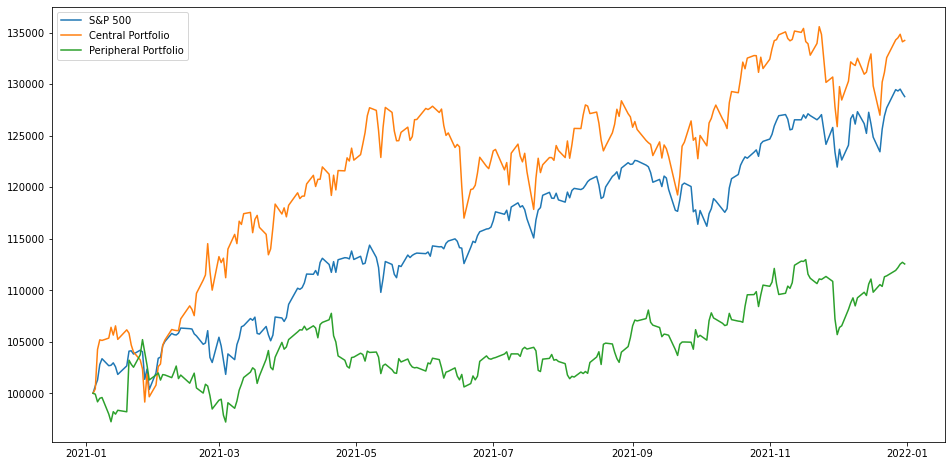

In [ ]:
figure, ax = plt.subplots(figsize=(16, 8))
snp_500_line = ax.plot(all_portfolios['sp500'], label='S&P 500')
central_portfolio_line = ax.plot(all_portfolios['central_portfolio'], label= 'Central Portfolio')
peripheral_portfolio_line = ax.plot(all_portfolios['peripheral_portfolio'], label= 'Peripheral Portfolio')
ax.legend(loc='upper left')
plt.show()

As seen from the above plot, it is clear that **the Central Portfolio stocks perform better and the Peripheral Portfolio stocks perform poorer in comparison to the S&P 500 stocks in 2021.**